# Calibration of the PDM

In [30]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil.relativedelta import relativedelta
import hvplot
import hvplot.pandas
import scipy
import winsound 
import warnings
pad = Path(os.getcwd())
if pad.name != "Python":
    pad_correct = Path("../../Python")
    os.chdir(pad_correct)
from functions.PDM import PDM, PDM_calibration_wrapper
from functions.performance_metrics import NSE, mNSE

exec_optimisation = True
if exec_optimisation:
    exec_write = True
    exec_read = False
else:
    exec_write = False
    exec_read = True
%load_ext autoreload 
%autoreload 2 

warnings.filterwarnings(action = 'ignore', category= RuntimeWarning)
warnings.filterwarnings(action = 'ignore', category= UserWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read in and process initial data

In [31]:
parameters_initial = pd.DataFrame({
    'cmax': 400.60999,
    'cmin':87.67600,
    'b':0.60000,
    'be':3.00000,
    'k1':8.00000,
    'k2':0.70000,
    'kb':5.04660,
    'kg':9000.00000,
    'St': 0.43043,
    'bg':1.00000,
    'tdly':2.00000,
    'qconst':0.00000,
    #'rainfac':0.00000 THIS IS NOT USED!
}, dtype = np.float32, index =[0])
display(parameters_initial)

area_zwalm_initial = np.single(109.2300034)
zwalm_shape = gpd.read_file('data/Zwalm_shape/zwalm_shapefile_emma_31370.shp')
area_zwalm_new = np.single(zwalm_shape.area[0]/10**6)
print('Area of the Zwalm by Cabus: ' + str(area_zwalm_initial) + '[km^2]')
print('Area of the Zwalm by shapefile: ' + str(area_zwalm_new) + '[km^2]')

,cmax,cmin,b,be,k1,k2,kb,kg,St,bg,tdly,qconst
0,400.609985,87.676003,0.6,3.0,8.0,0.7,5.0466,9000.0,0.43043,1.0,2.0,0.0


Area of the Zwalm by Cabus: 109.23[km^2]
Area of the Zwalm by shapefile: 115.208626[km^2]


For calibration, the bounds from Cabus are used! Unless for:
-  $b_e$  minimum from PDM as at LEAST a linear relationship!! take max 3 for $b_e$.
- $b_g$ is set to 1 and not calibrated further!
- $tdly$ suppose this can only be positive and not more than a day

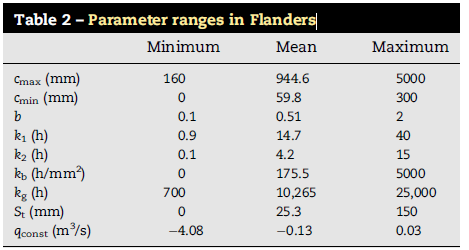

Info from the VMM

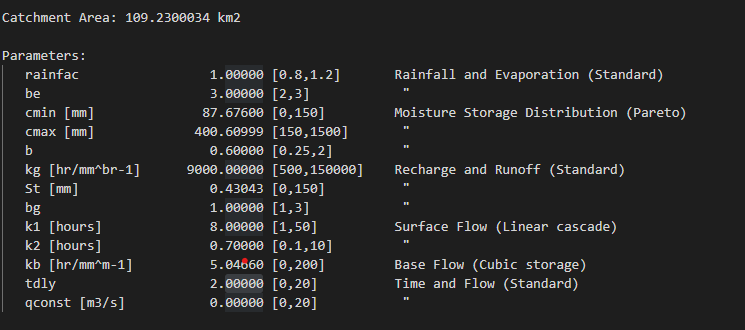

In [32]:
lower_bound = np.array([160,0,0.1,1,0.9,0.1,0,700,0,1,0,-0.03]) #21/12/2022: set stricter on qconst for avoiding negative flows
upper_bound = np.array([5000,300,2,3,40,15,5000,25000,150,1.000000000000001,20,0.03])
bounds_list = []
for i in range(len(lower_bound)):
    bounds_list.append((lower_bound[i],upper_bound[i]))
#bounds_opt = tuple(bounds_list)
bounds_opt = bounds_list
print(bounds_opt)

[(160.0, 5000.0), (0.0, 300.0), (0.1, 2.0), (1.0, 3.0), (0.9, 40.0), (0.1, 15.0), (0.0, 5000.0), (700.0, 25000.0), (0.0, 150.0), (1.0, 1.000000000000001), (0.0, 20.0), (-0.03, 0.03)]


Load in forcings and measured flows

First day of forcing data: 2012-01-01 00:00:00
Last day of forcing data: 2022-11-05 23:00:00


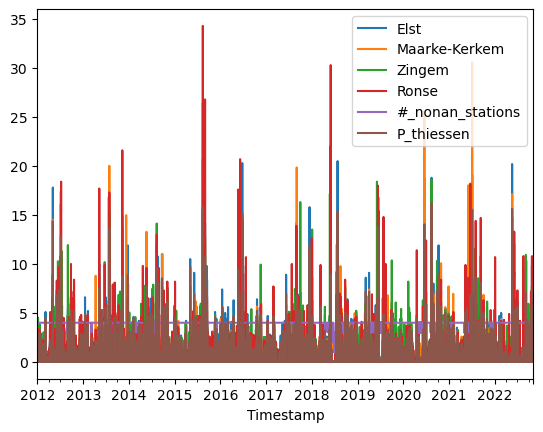

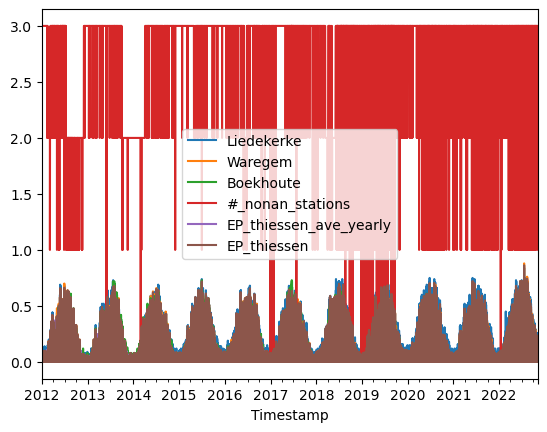

In [33]:
preprocess_output_folder = Path('data/Zwalm_data/preprocess_output')
p_zwalm = pd.read_pickle(preprocess_output_folder/'zwalm_p_thiessen.pkl')
ep_zwalm = pd.read_pickle(preprocess_output_folder/'zwalm_ep_thiessen.pkl')
ep_zwalm.loc[ep_zwalm['EP_thiessen'] <0, 'EP_thiessen'] = 0 #ADVICE OF NIKO 21/12/2022
#Temporary fix! 
#ep_zwalm.loc[np.isnan(ep_zwalm['EP_thiessen']),'EP_thiessen'] = 0

pywaterinfo_output_folder = Path("data/Zwalm_data/pywaterinfo_output")
Q_day = pd.read_pickle(pywaterinfo_output_folder/"Q_day.pkl")
Q_day = Q_day.set_index('Timestamp')
p_zwalm.set_index('Timestamp').plot()
ep_zwalm.set_index('Timestamp').plot()
print('First day of forcing data: ' + str(p_zwalm['Timestamp'].iloc[0]))
print('Last day of forcing data: ' + str(p_zwalm['Timestamp'].iloc[-1]))

In [34]:
p_zwalm.set_index('Timestamp')['#_nonan_stations'].hvplot()

:Curve   [Timestamp]   (#_nonan_stations)

First split up in 50/50
- Calibration: 2012-01-01 00:00 -> 2017-12-31 23:00 (period1)
- Validation: 2018-01-01 00:00 -> 2022-11-05 23:00 (period2)

Take ... months warmup period for EACH PERIOD 

In [35]:
warmup_months = 9
start_p1 = p_zwalm['Timestamp'].iloc[0]
start_endofwarmup_p1 = start_p1 + relativedelta(months = warmup_months)
end_p1 =  pd.Timestamp(datetime(year = 2017, month = 12, day = 31, hour = 23))
print('Characteristics of period 1: start = '  + str(start_p1) + ', start of post warmup = ' + str(start_endofwarmup_p1) + ' and end = ' + str(end_p1))

start_p2 = pd.Timestamp(datetime(year = 2018, month= 1, day = 1, hour = 0))
start_endofwarmup_p2 = start_p2 + relativedelta(months = warmup_months)
end_p2 = p_zwalm['Timestamp'].iloc[-1]
print('Characteristics of period 2: start = '  + str(start_p2) + ', start of post warmup = ' + str(start_endofwarmup_p2) + ' and end = ' + str(end_p2))

p1_period_excl_warmup = pd.date_range(start_endofwarmup_p1,end_p1,
freq = 'D') #used for scoring the model 
p1_period = pd.date_range(start_p1, end_p1, freq = 'H')
p2_period_excl_warmup = pd.date_range(start_endofwarmup_p2,end_p2,
freq = 'D') #used for scoring the model 
p2_period = pd.date_range(start_p2, end_p2, freq = 'H')
p_all_nowarmup = pd.date_range(start_endofwarmup_p1, end_p2)
p_all = pd.date_range(start_p1, end_p2)

#now subdivide ep data on p1 and p2
#for ease of selecting data, set time as index!
#select forcings for p1 period
p_zwalm_p1 = p_zwalm.set_index('Timestamp').loc[p1_period]
ep_zwalm_p1 = ep_zwalm.set_index('Timestamp').loc[p1_period]
#select forcings for p2 period
p_zwalm_p2 = p_zwalm.set_index('Timestamp').loc[p2_period]
ep_zwalm_p2 = ep_zwalm.set_index('Timestamp').loc[p2_period]


Characteristics of period 1: start = 2012-01-01 00:00:00, start of post warmup = 2012-10-01 00:00:00 and end = 2017-12-31 23:00:00
Characteristics of period 2: start = 2018-01-01 00:00:00, start of post warmup = 2018-10-01 00:00:00 and end = 2022-11-05 23:00:00


## Check initial performance of the model

In [36]:
deltat = np.single(1) #internal resolution =  1 hour
deltat_out = np.single(24) #output resolution = 24 hour
pd_zwalm_out_initial = PDM(P = p_zwalm['P_thiessen'].values, 
    EP = ep_zwalm['EP_thiessen'].values,
    t = p_zwalm['Timestamp'].values,
    area = area_zwalm_initial, deltat = deltat, deltatout = deltat_out ,
    parameters = parameters_initial)
pd_zwalm_out_initial = pd_zwalm_out_initial.set_index(['Time'])

# check (m)NSE 
pd_zwalm_out_initial_p2 = pd_zwalm_out_initial[start_endofwarmup_p2:end_p2]
nse_initial_p2 = NSE(
    pd_zwalm_out_initial_p2['qmodm3s'],
    Q_day.loc[start_endofwarmup_p2:end_p2,'Value'].values
)
mnse_initial_p2 = mNSE(
    pd_zwalm_out_initial_p2['qmodm3s'],
    Q_day.loc[start_endofwarmup_p2:end_p2,'Value'].values
)
print('NSE on p2 for initial set:' + str(nse_initial_p2))
print('mNSE on p2 for initial set:' + str(mnse_initial_p2))

pd_zwalm_out_initial_p1 = pd_zwalm_out_initial[start_endofwarmup_p1:end_p1]
nse_initial_p1 = NSE(
    pd_zwalm_out_initial_p1['qmodm3s'],
    Q_day.loc[start_endofwarmup_p1:end_p1,'Value'].values
)
mnse_initial_p1 = mNSE(
    pd_zwalm_out_initial_p1['qmodm3s'],
    Q_day.loc[start_endofwarmup_p1:end_p1,'Value'].values
)
print('NSE on p1 for initial set:' + str(nse_initial_p1))
print('mNSE on p1 for initial set:' + str(mnse_initial_p1))

nse_initial = NSE(
    pd_zwalm_out_initial.loc[start_endofwarmup_p1:end_p2,'qmodm3s'].values,
    Q_day.loc[start_endofwarmup_p1:end_p2,'Value'].values
)
mnse_initial = mNSE(
    pd_zwalm_out_initial.loc[start_endofwarmup_p1:end_p2,'qmodm3s'].values,
    Q_day.loc[start_endofwarmup_p1:end_p2,'Value'].values
)
print('NSE for initial set:' + str(nse_initial))
print('mNSE for initial set:' + str(mnse_initial))
 

NSE on p2 for initial set:0.7354573033607552
mNSE on p2 for initial set:0.5236851328175385
NSE on p1 for initial set:0.26165737923565846
mNSE on p1 for initial set:0.24204418421978235
NSE for initial set:0.4707928997535843
mNSE for initial set:0.3688992096969794


In [37]:
#fig, ax = plt.subplots(figsize = (10,6))
pd_zwalm_out_initial['qmodm3s'].hvplot(alpha = 0.7, frame_width = 900, frame_height = 400) * Q_day['Value'].hvplot()


:Overlay
   .Curve.Qmodm3s :Curve   [Time]   (qmodm3s)
   .Curve.Value   :Curve   [Timestamp]   (Value)

mainly on the first period, calibration needs to be improved!

## Calibration

### Calibration on period 1, validation on period 2 with NSE

In [38]:
goal_function = lambda param: -PDM_calibration_wrapper(
    param, parameters_initial.columns, 'NSE',p_zwalm_p1['P_thiessen'].values,
    ep_zwalm_p1['EP_thiessen'].values, area_zwalm_new, deltat,
    deltat_out, p1_period.values, p1_period_excl_warmup.values, Q_day['Value'], m =2
)

init_reshaped = parameters_initial.values.flatten()

Nfeval = 1
def callback_personal(Xi):
    global Nfeval
    print(Nfeval)#type:ignore
    print('Current parameter set' + str(Xi))
    Nfeval += 1#type:ignore

In [39]:
if exec_optimisation:
    optimize_result_p1 = scipy.optimize.minimize(
        goal_function, init_reshaped, method = 'Nelder-Mead',
        callback = callback_personal, 
        bounds = bounds_list,
        options = {'fatol':0.001}
    ) #has to be (n,) for initial valeus
# Read in and write out data
duration = 1000
freq = 350
winsound.Beep(freq, duration)
if exec_write:
    p1_opt_parameters = pd.DataFrame(optimize_result_p1.x.reshape(1,-1))#type:ignore
    p1_opt_parameters.columns = parameters_initial.columns
    p1_opt_parameters.to_csv('data/Zwalm_PDM_parameters/p1_opt_param_NSE_qconst_strict_m_2.csv')
if exec_read:
    p1_opt_parameters = pd.read_csv('data/Zwalm_PDM_parameters/p1_opt_param.csv', index_col= False)


1
Current parameter set[4.20640485e+02 8.76760025e+01 6.00000024e-01 3.00000000e+00
 8.00000000e+00 6.99999988e-01 5.04659986e+00 9.00000000e+03
 4.30429995e-01 1.00000000e+00 2.00000000e+00 0.00000000e+00]
2
Current parameter set[4.20640485e+02 8.76760025e+01 6.00000024e-01 3.00000000e+00
 8.00000000e+00 6.99999988e-01 5.04659986e+00 9.00000000e+03
 4.30429995e-01 1.00000000e+00 2.00000000e+00 0.00000000e+00]
3
Current parameter set[4.20640485e+02 8.76760025e+01 6.00000024e-01 3.00000000e+00
 8.00000000e+00 6.99999988e-01 5.04659986e+00 9.00000000e+03
 4.30429995e-01 1.00000000e+00 2.00000000e+00 0.00000000e+00]
4
Current parameter set[4.20640485e+02 8.76760025e+01 6.00000024e-01 3.00000000e+00
 8.00000000e+00 6.99999988e-01 5.04659986e+00 9.00000000e+03
 4.30429995e-01 1.00000000e+00 2.00000000e+00 0.00000000e+00]
5
Current parameter set[4.20640485e+02 8.76760025e+01 6.00000024e-01 3.00000000e+00
 8.00000000e+00 6.99999988e-01 5.04659986e+00 9.00000000e+03
 4.30429995e-01 1.00000000e

Running model on period 1 = calibration

In [40]:
print('NSE optimised on p1')
display(p1_opt_parameters[parameters_initial.columns])
print('Original')
display(parameters_initial)

NSE optimised on p1


,cmax,cmin,b,be,k1,k2,kb,kg,St,bg,tdly,qconst
0,643.698297,250.201433,0.404917,3.0,17.348258,0.101787,52.418673,14651.741773,0.136706,1.0,0.0,-0.009588


Original


,cmax,cmin,b,be,k1,k2,kb,kg,St,bg,tdly,qconst
0,400.609985,87.676003,0.6,3.0,8.0,0.7,5.0466,9000.0,0.43043,1.0,2.0,0.0


NSE on calibration period p1  excluding warm-up: 0.6211837627049557
mNSE on calibration period p1  excluding warm-up: 0.31563077877519663
-----------------------------------------------------------------------
NSE on p1 for initial parameter set excluding warm-up:0.26165737923565846
mNSE on p1 for initial set excluding warm-up:0.24204418421978235


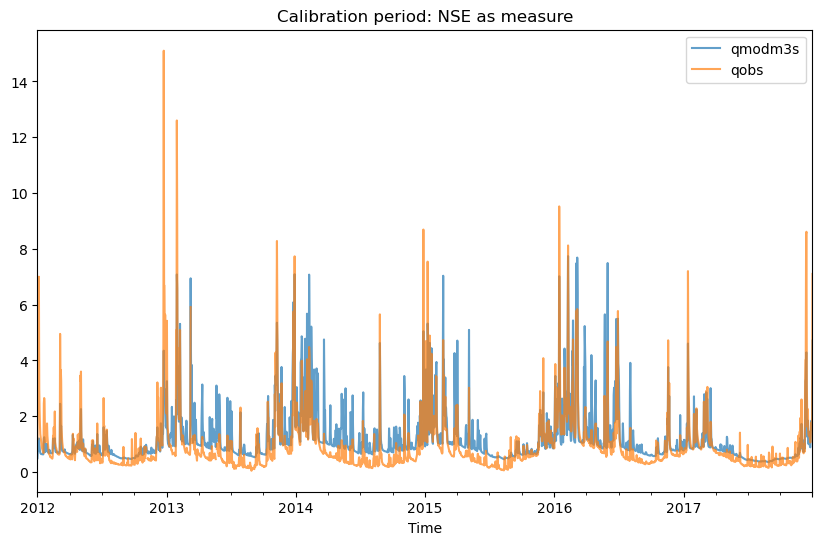

In [41]:
pd_zwalm_outp1_p1opt = PDM(P = p_zwalm_p1['P_thiessen'].values, 
    EP = ep_zwalm_p1['EP_thiessen'].values,
    t = p1_period.values, area = area_zwalm_new, deltat = deltat, deltatout = deltat_out ,
    parameters = p1_opt_parameters)#type:ignore

Q_day_join = Q_day.rename(columns = {'Time':'Timestamp','Value':'qobs'})
pd_zwalm_outp1_p1opt = pd_zwalm_outp1_p1opt.join(Q_day_join, on = 'Time', how = 'left')
pd_zwalm_outp1_p1opt = pd_zwalm_outp1_p1opt.set_index('Time')
fig, ax = plt.subplots(figsize = (10,6))
pd_zwalm_outp1_p1opt.plot(ax =ax,y = ['qmodm3s','qobs'], alpha = 0.7, title = 'Calibration period: NSE as measure')

nse_p1_p1opt = NSE(
    pd_zwalm_outp1_p1opt.loc[p1_period_excl_warmup, 'qmodm3s'],
    pd_zwalm_outp1_p1opt.loc[p1_period_excl_warmup, 'qobs']
)
mnse_p1_p1opt = mNSE(
    pd_zwalm_outp1_p1opt.loc[p1_period_excl_warmup, 'qmodm3s'],
    pd_zwalm_outp1_p1opt.loc[p1_period_excl_warmup, 'qobs']
)
print('NSE on calibration period p1  excluding warm-up: ' +str(nse_p1_p1opt))
print('mNSE on calibration period p1  excluding warm-up: ' +str(mnse_p1_p1opt))
print('-----------------------------------------------------------------------')
print('NSE on p1 for initial parameter set excluding warm-up:' + str(nse_initial_p1))
print('mNSE on p1 for initial set excluding warm-up:' + str(mnse_initial_p1))

Base flow is off...

Running model below on period 2 for validation

NSE on validation period p2 excluding warm-up: 0.6907205102646982
mNSE on validation period p2 excluding warm-up: 0.47500416582522675
------------------------------------------------------------------
NSE on p2 for initial set:0.7354573033607552
mNSE on p2 for initial set: 0.5236851328175385


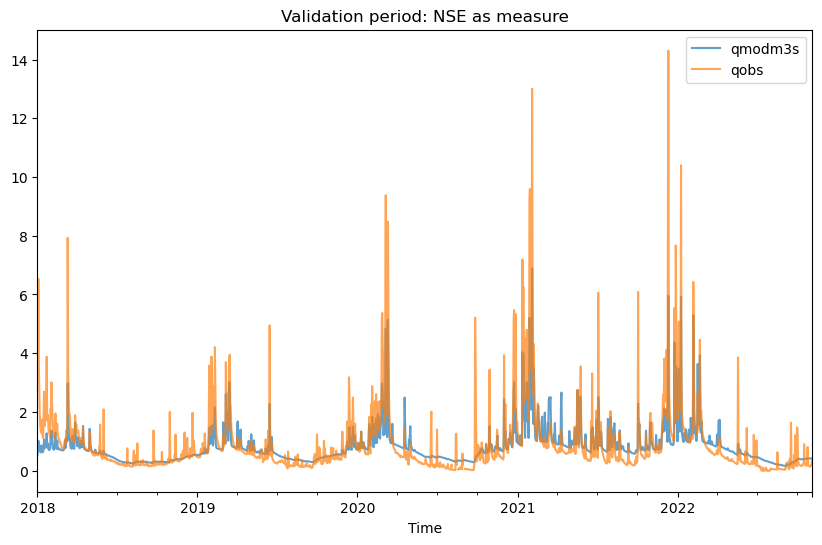

In [42]:
pd_zwalm_outp2_p1opt = PDM(P = p_zwalm_p2['P_thiessen'].values, 
    EP = ep_zwalm_p2['EP_thiessen'].values,
    t = p2_period.values, area = area_zwalm_new, deltat = deltat, deltatout = deltat_out ,
    parameters = p1_opt_parameters)#type:ignore
pd_zwalm_outp2_p1opt = pd_zwalm_outp2_p1opt.join(Q_day_join, on = 'Time', how = 'left')
pd_zwalm_outp2_p1opt = pd_zwalm_outp2_p1opt.set_index('Time')
fig, ax = plt.subplots(figsize = (10,6))
pd_zwalm_outp2_p1opt.plot(ax = ax, y = ['qmodm3s','qobs'], alpha = 0.7, title = 'Validation period: NSE as measure')

nse_p2_p1opt = NSE(
    pd_zwalm_outp2_p1opt.loc[p2_period_excl_warmup, 'qmodm3s'],
    pd_zwalm_outp2_p1opt.loc[p2_period_excl_warmup, 'qobs']
)
mnse_p2_p1opt = mNSE(
    pd_zwalm_outp2_p1opt.loc[p2_period_excl_warmup, 'qmodm3s'],
    pd_zwalm_outp2_p1opt.loc[p2_period_excl_warmup, 'qobs']
)
print('NSE on validation period p2 excluding warm-up: ' +str(nse_p2_p1opt))
print('mNSE on validation period p2 excluding warm-up: ' +str(mnse_p2_p1opt))
print('------------------------------------------------------------------')
print('NSE on p2 for initial set:' + str(nse_initial_p2))
print('mNSE on p2 for initial set: ' + str(mnse_initial_p2))


### Calibration on period 1, validation on period 2 with mNSE

In [43]:
goal_function_mNSE = lambda param: -PDM_calibration_wrapper(
    param, parameters_initial.columns, 'mNSE',p_zwalm_p1['P_thiessen'].values,
    ep_zwalm_p1['EP_thiessen'].values, area_zwalm_new, deltat,
    deltat_out, p1_period.values, p1_period_excl_warmup.values, Q_day['Value'], m = 2
)
Nfeval = 1
if exec_optimisation:
    optimize_result_p1_mNSE = scipy.optimize.minimize(
        goal_function_mNSE, init_reshaped, method = 'Nelder-Mead',
        callback = callback_personal, 
        bounds = bounds_list,
        options = {'fatol':0.001}
    ) #has to be (n,) for initial valeus
duration = 1000
freq = 350
winsound.Beep(freq, duration)
# Read in and write out data
if exec_write:
    p1_opt_parameters_mNSE = pd.DataFrame(optimize_result_p1_mNSE.x.reshape(1,-1))#type:ignore
    p1_opt_parameters_mNSE.columns = parameters_initial.columns
    p1_opt_parameters_mNSE.to_csv('data/Zwalm_PDM_parameters/p1_opt_param_mNSE_qconst_strict_m_2.csv')
    #p1_opt_parameters_mNSE.to_csv('data/Zwalm_PDM_parameters/p1_opt_param_mNSE_initial_area.csv')
if exec_read:
    p1_opt_parameters_mNSE = pd.read_csv('data/Zwalm_PDM_parameters/p1_opt_param_mNSE.csv')
    #p1_opt_parameters_mNSE = pd.read_csv('data/Zwalm_PDM_parameters/p1_opt_param_mNSE_initial_area.csv')

1
Current parameter set[4.05617610e+02 8.87719525e+01 5.40000021e-01 3.00000000e+00
 8.10000000e+00 7.08749988e-01 5.10968236e+00 9.11250000e+03
 4.35810370e-01 1.00000000e+00 2.02500000e+00 6.25000000e-05]
2
Current parameter set[4.05617610e+02 8.87719525e+01 5.40000021e-01 3.00000000e+00
 8.10000000e+00 7.08749988e-01 5.10968236e+00 9.11250000e+03
 4.35810370e-01 1.00000000e+00 2.02500000e+00 6.25000000e-05]
3
Current parameter set[4.05617610e+02 8.87719525e+01 5.40000021e-01 3.00000000e+00
 8.10000000e+00 7.08749988e-01 5.10968236e+00 9.11250000e+03
 4.35810370e-01 1.00000000e+00 2.02500000e+00 6.25000000e-05]
4
Current parameter set[4.05617610e+02 8.87719525e+01 5.40000021e-01 3.00000000e+00
 8.10000000e+00 7.08749988e-01 5.10968236e+00 9.11250000e+03
 4.35810370e-01 1.00000000e+00 2.02500000e+00 6.25000000e-05]
5
Current parameter set[4.05617610e+02 8.87719525e+01 5.40000021e-01 3.00000000e+00
 8.10000000e+00 7.08749988e-01 5.10968236e+00 9.11250000e+03
 4.35810370e-01 1.00000000e

ZeroDivisionError: division by zero

Experiment: test one of the global optimisers of scipy (dual annealing is used)

In [21]:
# if exec_optimisation:
#     optimize_result_p1_mNSE_global = scipy.optimize.dual_annealing(
#         func = goal_function_mNSE, x0 = init_reshaped,
#         #callback = callback_personal, 
#         bounds = bounds_list,
#         #options = {'xatol':0.01, 'fatol':0.001}
#     ) #has to be (n,) for initial valeus

In [22]:
print('mNSE optimised on p1')
display(p1_opt_parameters_mNSE[parameters_initial.columns])
print('Original')
display(parameters_initial)

mNSE optimised on p1


,cmax,cmin,b,be,k1,k2,kb,kg,St,bg,tdly,qconst
0,451.243704,109.76662,0.152586,3.0,7.854396,0.692616,4.749324,11702.630144,0.442172,1.0,2.109854,-0.000248


Original


,cmax,cmin,b,be,k1,k2,kb,kg,St,bg,tdly,qconst
0,400.609985,87.676003,0.6,3.0,8.0,0.7,5.0466,9000.0,0.43043,1.0,2.0,0.0


NSE on calibration period p1  excluding warm-up: 0.6565799287109493
mNSE on calibration period p1  excluding warm-up: 0.39197271034876724
-----------------------------------------------------------------------
NSE on p1 for initial parameter set excluding warm-up:0.26165737923565846
mNSE on p1 for initial set excluding warm-up:0.24204418421978235


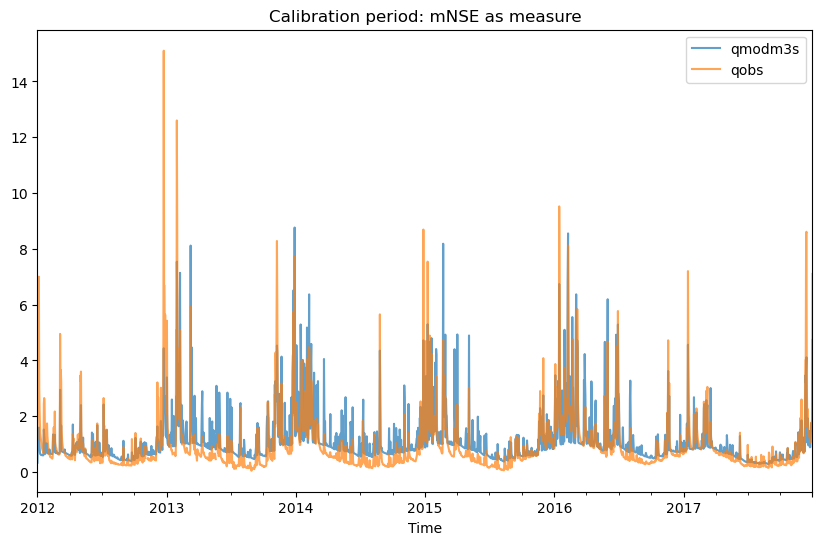

In [23]:
pd_zwalm_outp1_p1optmNSE = PDM(P = p_zwalm_p1['P_thiessen'].values, 
    EP = ep_zwalm_p1['EP_thiessen'].values,
    t = p1_period.values, area = area_zwalm_initial, deltat = deltat, deltatout = deltat_out ,
    parameters = p1_opt_parameters_mNSE)#type:ignore

Q_day_join = Q_day.rename(columns = {'Time':'Timestamp','Value':'qobs'})
pd_zwalm_outp1_p1optmNSE = pd_zwalm_outp1_p1optmNSE.join(Q_day_join, on = 'Time', how = 'left')
pd_zwalm_outp1_p1optmNSE = pd_zwalm_outp1_p1optmNSE.set_index('Time')
fig, ax = plt.subplots(figsize = (10,6))
pd_zwalm_outp1_p1optmNSE.plot(ax =ax,y = ['qmodm3s','qobs'], alpha = 0.7, title = 'Calibration period: mNSE as measure')

nse_p1_p1optmNSE = NSE(
    pd_zwalm_outp1_p1optmNSE.loc[p1_period_excl_warmup, 'qmodm3s'],
    pd_zwalm_outp1_p1optmNSE.loc[p1_period_excl_warmup, 'qobs']
)
mnse_p1_p1optmNSE = mNSE(
    pd_zwalm_outp1_p1optmNSE.loc[p1_period_excl_warmup, 'qmodm3s'],
    pd_zwalm_outp1_p1optmNSE.loc[p1_period_excl_warmup, 'qobs']
)
print('NSE on calibration period p1  excluding warm-up: ' +str(nse_p1_p1optmNSE))
print('mNSE on calibration period p1  excluding warm-up: ' +str(mnse_p1_p1optmNSE))
print('-----------------------------------------------------------------------')
print('NSE on p1 for initial parameter set excluding warm-up:' + str(nse_initial_p1))
print('mNSE on p1 for initial set excluding warm-up:' + str(mnse_initial_p1))

NSE on validation period p2 excluding warm-up: 0.7313906051872148
mNSE on validation period p2 excluding warm-up: 0.49412395373399987
------------------------------------------------------------------
NSE on p2 for initial set:0.7354573033607552
mNSE on p2 for initial set: 0.5236851328175385


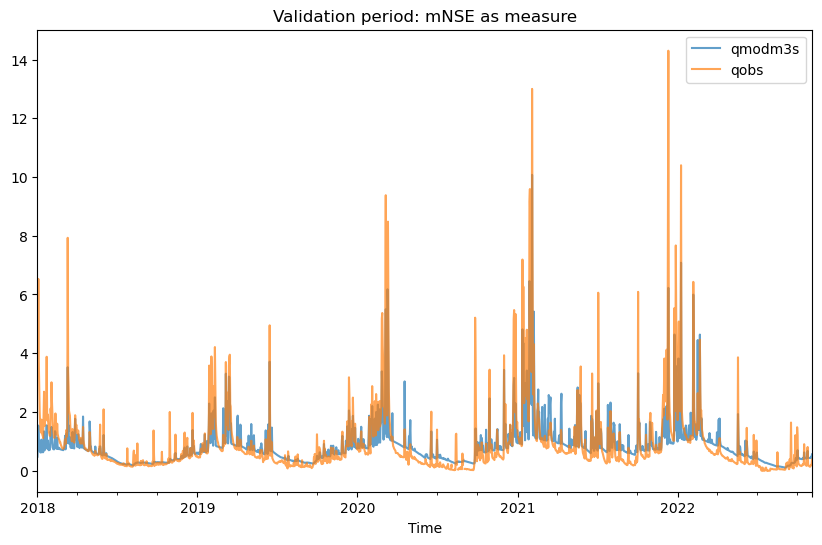

In [24]:
pd_zwalm_outp2_p1optmNSE = PDM(P = p_zwalm_p2['P_thiessen'].values, 
    EP = ep_zwalm_p2['EP_thiessen'].values,
    t = p2_period.values, area = area_zwalm_new, deltat = deltat, deltatout = deltat_out ,
    parameters = p1_opt_parameters_mNSE)#type:ignore
pd_zwalm_outp2_p1optmNSE = pd_zwalm_outp2_p1optmNSE.join(Q_day_join, on = 'Time', how = 'left')
pd_zwalm_outp2_p1optmNSE = pd_zwalm_outp2_p1optmNSE.set_index('Time')
fig, ax = plt.subplots(figsize = (10,6))
pd_zwalm_outp2_p1optmNSE.plot(ax = ax, y = ['qmodm3s','qobs'], alpha = 0.7, title = 'Validation period: mNSE as measure')

nse_p2_p1optmNSE = NSE(
    pd_zwalm_outp2_p1optmNSE.loc[p2_period_excl_warmup, 'qmodm3s'],
    pd_zwalm_outp2_p1optmNSE.loc[p2_period_excl_warmup, 'qobs']
)
mnse_p2_p1optmNSE = mNSE(
    pd_zwalm_outp2_p1optmNSE.loc[p2_period_excl_warmup, 'qmodm3s'],
    pd_zwalm_outp2_p1optmNSE.loc[p2_period_excl_warmup, 'qobs']
)
print('NSE on validation period p2 excluding warm-up: ' +str(nse_p2_p1optmNSE))
print('mNSE on validation period p2 excluding warm-up: ' +str(mnse_p2_p1optmNSE))
print('------------------------------------------------------------------')
print('NSE on p2 for initial set:' + str(nse_initial_p2))
print('mNSE on p2 for initial set: ' + str(mnse_initial_p2))


# Test mNSE calibration on full set

In [25]:
goal_function_mNSE = lambda param: -PDM_calibration_wrapper(
    param, parameters_initial.columns, 'mNSE',p_zwalm['P_thiessen'].values,
    ep_zwalm['EP_thiessen'].values, area_zwalm_new, deltat,
    deltat_out, p_all.values, p_all_nowarmup.values, Q_day['Value']
)
Nfeval = 1
if exec_optimisation:
    optimize_result_p1_mNSE = scipy.optimize.minimize(
        goal_function_mNSE, init_reshaped, method = 'Nelder-Mead',
        callback = callback_personal, 
        bounds = bounds_list,
        options = {'fatol':0.001}
    ) #has to be (n,) for initial valeus
duration = 1000
freq = 350
winsound.Beep(freq, duration)
# Read in and write out data
if exec_write:
    pall_opt_parameters_mNSE = pd.DataFrame(optimize_result_p1_mNSE.x.reshape(1,-1))#type:ignore
    pall_opt_parameters_mNSE.columns = parameters_initial.columns
    pall_opt_parameters_mNSE.to_csv('data/Zwalm_PDM_parameters/pall_opt_param_mNSE_initial_area.csv')
if exec_read:
    pall_opt_parameters_mNSE = pd.read_csv('data/Zwalm_PDM_parameters/pall_opt_param_mNSE.csv')
    #p1_opt_parameters_mNSE = pd.read_csv('data/Zwalm_PDM_parameters/p1_opt_param_mNSE_initial_area.csv')

1
Current parameter set[4.05617610e+02 8.87719525e+01 5.40000021e-01 3.00000000e+00
 8.10000000e+00 7.08749988e-01 5.10968236e+00 9.11250000e+03
 4.35810370e-01 1.00000000e+00 2.02500000e+00 6.25000000e-05]
2
Current parameter set[4.05617610e+02 8.87719525e+01 5.40000021e-01 3.00000000e+00
 8.10000000e+00 7.08749988e-01 5.10968236e+00 9.11250000e+03
 4.35810370e-01 1.00000000e+00 2.02500000e+00 6.25000000e-05]
3
Current parameter set[4.05617610e+02 8.87719525e+01 5.40000021e-01 3.00000000e+00
 8.10000000e+00 7.08749988e-01 5.10968236e+00 9.11250000e+03
 4.35810370e-01 1.00000000e+00 2.02500000e+00 6.25000000e-05]
4
Current parameter set[4.05617610e+02 8.87719525e+01 5.40000021e-01 3.00000000e+00
 8.10000000e+00 7.08749988e-01 5.10968236e+00 9.11250000e+03
 4.35810370e-01 1.00000000e+00 2.02500000e+00 6.25000000e-05]
5
Current parameter set[4.05617610e+02 8.87719525e+01 5.40000021e-01 3.00000000e+00
 8.10000000e+00 7.08749988e-01 5.10968236e+00 9.11250000e+03
 4.35810370e-01 1.00000000e

In [45]:
pd_zwalm_out_full = PDM(P = p_zwalm['P_thiessen'].values, 
    EP = ep_zwalm['EP_thiessen'].values,
    t = p_zwalm['Timestamp'].values,
    area = area_zwalm_new, deltat = deltat, deltatout = deltat_out ,
    parameters = pall_opt_parameters_mNSE)
pd_zwalm_out_full = pd_zwalm_out_full.set_index(['Time'])
display(pd_zwalm_out_full['qmodm3s'].hvplot(alpha = 0.7, frame_width = 900, 
frame_height = 400, title = 'All data use for calibration') * Q_day['Value'].hvplot(alpha = 0.7))
nse_whole = NSE(
    pd_zwalm_out_full.loc[start_endofwarmup_p1:end_p2,'qmodm3s'].values,
    Q_day.loc[start_endofwarmup_p1:end_p2,'Value'].values
)
print('NSE when trained on whole dataset and performance for this whole set: '+ str(nse_whole))

:Overlay
   .Curve.Qmodm3s :Curve   [Time]   (qmodm3s)
   .Curve.Value   :Curve   [Timestamp]   (Value)

NSE when trained on whole dataset and performance for this whole set; 0.6992777600628761


## Test parameters Jarne

In [27]:
parameters_jarne = pd.DataFrame({
    'cmax': 987.5791,
    'cmin':89.8381,
    'b':1.5247,
    'be':1.8482,
    'k1':5.6988,
    'k2':9.0651,
    'kb':1616.9,
    'kg':16169,
    'St': 45.5208,
    'bg':1.1444,
    'tdly':1,
    'qconst':-0.6407,
    #'rainfac':0.00000 THIS IS NOT USED!
}, dtype = np.float32, index =[0])
display(parameters_jarne)
parameters_jarne2 = pd.DataFrame({
    'cmax': 665.4593,
    'cmin':223.3913,
    'b':0.7305,
    'be':1.8673,
    'k1':9.5112,
    'k2':6.6053,
    'kb':3147.1,
    'kg':12795,
    'St': 116.7857,
    'bg':1.1012,
    'tdly':9,
    'qconst':0.0260,
    #'rainfac':0.00000 THIS IS NOT USED!
}, dtype = np.float32, index =[0])
display(parameters_jarne2)

,cmax,cmin,b,be,k1,k2,kb,kg,St,bg,tdly,qconst
0,987.579102,89.838097,1.5247,1.8482,5.6988,9.0651,1616.900024,16169.0,45.520802,1.1444,1.0,-0.6407


,cmax,cmin,b,be,k1,k2,kb,kg,St,bg,tdly,qconst
0,665.45929,223.391296,0.7305,1.8673,9.5112,6.6053,3147.100098,12795.0,116.785698,1.1012,9.0,0.026


In [28]:
pd_zwalm_out_jarne = PDM(P = p_zwalm['P_thiessen'].values, 
    EP = ep_zwalm['EP_thiessen'].values,
    t = p_zwalm['Timestamp'].values,
    area = area_zwalm_initial, deltat = deltat, deltatout = deltat_out ,
    parameters = parameters_jarne2)
pd_zwalm_out_jarne = pd_zwalm_out_jarne.set_index(['Time'])

In [29]:
pd_zwalm_out_jarne['qmodm3s'].hvplot(alpha = 0.7, frame_width = 900, frame_height = 400) * Q_day['Value'].hvplot()


:Overlay
   .Curve.Qmodm3s :Curve   [Time]   (qmodm3s)
   .Curve.Value   :Curve   [Timestamp]   (Value)

## Test calibrate ONLY on qconst to fix the baseflow offset!! 

In [30]:
# lower_bound = np.array([160,0,0.1,1,0.9,0.1,0,700,0,1,0,-4.08])
# upper_bound = np.array([5000,300,2,3,40,15,5000,25000,150,1.000000000000001,20,0.03])

goal_function_mNSE = lambda param: -PDM_calibration_wrapper(
    param, parameters_initial.columns, 'mNSE',p_zwalm_p1['P_thiessen'].values,
    ep_zwalm_p1['EP_thiessen'].values, area_zwalm_initial, deltat,
    deltat_out, p1_period.values, p1_period_excl_warmup.values, Q_day['Value']
)
def goal_function_qconst (q_const, parameters):
    parameters[0][-1] = q_const
    performance = goal_function_mNSE(parameters)
    return performance
goal_function_qconst_scipy = lambda qconst: goal_function_qconst(qconst, parameters_initial.values)
bounds = [-4,5]
Nfeval = 1
optimize_result_p1_qconst = scipy.optimize.brute(
    goal_function_qconst_scipy, ranges = (slice(-1,1,0.1),)
    #callback = callback_personal
) #has to be (n,) for initial valeus

In [31]:
optimize_result_p1_qconst

array([-0.17078125])

In [32]:
parameters_qconst = parameters_initial.copy()
parameters_qconst['qconst'] = optimize_result_p1_qconst
parameters_qconst

,cmax,cmin,b,be,k1,k2,kb,kg,St,bg,tdly,qconst
0,400.609985,87.676003,0.6,3.0,8.0,0.7,5.0466,9000.0,0.43043,1.0,2.0,-0.170781


In [33]:
pd_zwalm_out_qconst = PDM(P = p_zwalm['P_thiessen'].values, 
    EP = ep_zwalm['EP_thiessen'].values,
    t = p_zwalm['Timestamp'].values,
    area = area_zwalm_new, deltat = deltat, deltatout = deltat_out ,
    parameters = parameters_qconst)
pd_zwalm_out_qconst = pd_zwalm_out_qconst.set_index('Time')
display(pd_zwalm_out_qconst['qmodm3s'].hvplot() * Q_day['Value'].hvplot())


:Overlay
   .Curve.Qmodm3s :Curve   [Time]   (qmodm3s)
   .Curve.Value   :Curve   [Timestamp]   (Value)

In [34]:
pd_zwalm_out_qconst.loc[start_endofwarmup_p1:end_p2,'qmodm3s'].values

array([0.18190296, 0.18980347, 0.38219813, ..., 0.39358747, 0.70976335,
       0.41480607], dtype=float32)

In [35]:
nse_whole = NSE(
    pd_zwalm_out_qconst.loc[start_endofwarmup_p1:end_p2,'qmodm3s'].values,
    Q_day.loc[start_endofwarmup_p1:end_p2,'Value'].values
)
print(nse_whole)

0.423862118647628


### Calibration on period 1, validation on period 2 with NSE